In [1]:
! eups list -s lsst_distrib

   21.0.0-2-g8e5b5ee+5e94e19eb4 	w_2021_12 w_latest current setup


Following Eric's instruction, visualising some processed data in the SLAC Jupyter is the goal of this notebook. We assume the data have been already in a butler repository. The detail description can be found [here (Eric's confluence note)](https://confluence.slac.stanford.edu/pages/viewpage.action?pageId=245696522)

## Setting Jupyter environment on a SLAC Cent machines

I'm running this notebook using JupyterLab running at a SLAC's cent7 machine.
On a cent7 machine you have to know which machine you are on

```
> hostname
cent7c
```

So you are on cent7c. Then configure ~/.ssh/config file so that things get easier. Put something similar (change user name as yours) below
```
Host ki-ls 
    User youtsumi
    Hostname ki-ls.slac.stanford.edu
    GSSAPIDelegateCredentials yes

Host cent7
    User youtsumi
    Hostname cent7c.slac.stanford.edu
    ProxyCommand ssh ki-ls /usr/bin/nc %h %p
    GSSAPIDelegateCredentials yes 
```
This is a "bookmark" in the ssh world. Complicate options can be encapsulated in this config file. Once you make this config file, commanding
```
> ssh cent7
```
will let you login to cent7. Then you have to setup your LSST environment
```
> source /u/ek/echarles/setup_dm_stack.bashrc
> lsst_setup
> jupyter lab
```
copy a Jupyter token, and then make another ssh connection to make you a port forwarding by the following command
```
> ssh -L 60088:localhost:8888 cent7
```
60088 can be different. I think it should be unique in a computer. So you have to pick some number (reasonably large but below 62535 because small numbers are reserved). Then you can use Jupyter from your local browser if you access to localhost:60088 with the token you got above

Then, working inside the Jupyter world

## Doing LSST specific stuff
Import Butler

see the detailed description https://pipelines.lsst.io/modules/lsst.daf.butler/index.html

In [2]:
from lsst.daf.butler import Butler

And other stuff for plotting or handling data...

In [3]:
%matplotlib inline

import pylab as plt
# Stack imports
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

import numpy

Set the path to the Butler repository and import a Butler

In [4]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_test/butler.yaml"
butler = Butler(repo_path)

Walk through the butler database by following
https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Basics/Gen3ButlerTutorial.ipynb

In [5]:
registry = butler.registry

Here we list collections we have. It can be raw data or processed image, catalog or something else

In [6]:
for c in registry.queryCollections():
    print(c)    

LSSTCam/raw/all
u/echarles/calib/run_12781
u/echarles/calib/run_12781/20210322T182107Z
/calib/run_12781
u/echarles/calib/bias/run_12781
u/echarles/calib/bias/run_12781/20210322T183606Z
LSSTCam/calib
LSSTCam/calib/unbounded
u/echarles/calib/run_12783/dark
u/echarles/calib/run_12783/dark/20210322T202029Z
u/echarles/calib/defects/run_12781
u/echarles/calib/defects/run_12781/20210322T224240Z
u/echarles/sandbox/eo_bias
u/echarles/sandbox/eo_bias/20210324T033754Z
u/echarles/calib/bias/run_12781/20210324T162502Z
u/echarles/calib/run_12783/dark/20210324T163856Z
u/echarles/calib/defects/run_12781/20210324T164529Z
u/youtsumi/spot/20210324
u/youtsumi/spot/20210324/20210325T013830Z
u/youtsumi/spot/20210324a
u/youtsumi/spot/20210324a/20210325T034308Z
u/youtsumi/spot/20210324c
u/youtsumi/spot/20210324c/20210325T041707Z
u/echarles/calib/bias/run_12781/20210326T180033Z
u/youtsumi/spot/20210402a
u/youtsumi/spot/20210402a/20210402T185535Z
u/youtsumi/spot/20210402b
u/youtsumi/spot/20210402b/20210402T1900

pick one of those and put in collections below

In [7]:
collections = 'u/youtsumi/spot/20210402c'
#collections = 'u/echarles/calib/bias/run_12781/20210326T180033Z'
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )

79124 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpBiasProc_full', {band, instrument, detector, physical_filter, exposure}, Exposure)
4 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
Error DatasetType('bias_full', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
4 DatasetType('isr_config', {}, Config)
0 DatasetType('cpCombine_config', {}, Config)
4 DatasetType('packages', {}, Packages)
0 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
Error DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpDarkIsr', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDarkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDark_metadata', {band, instrument, detect

pick one of the datatype from above but having ExposureF at the end or relevant. Then let's display how they look

{instrument: 'LSSTCam', detector: 29, exposure: 3020112501820, ...}


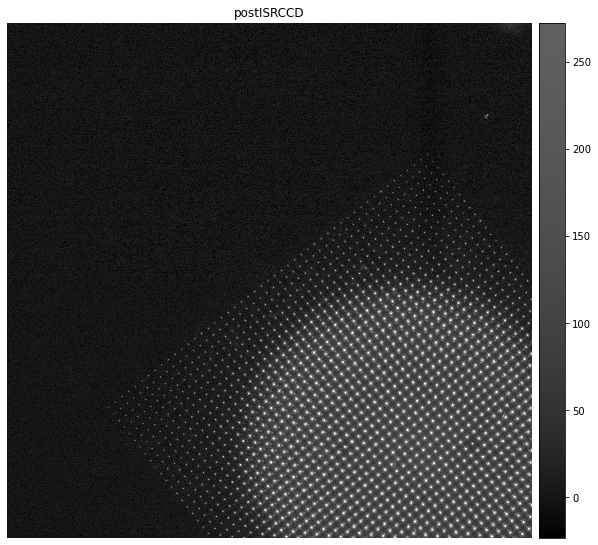

{instrument: 'LSSTCam', detector: 29, exposure: 3020112501820, ...}


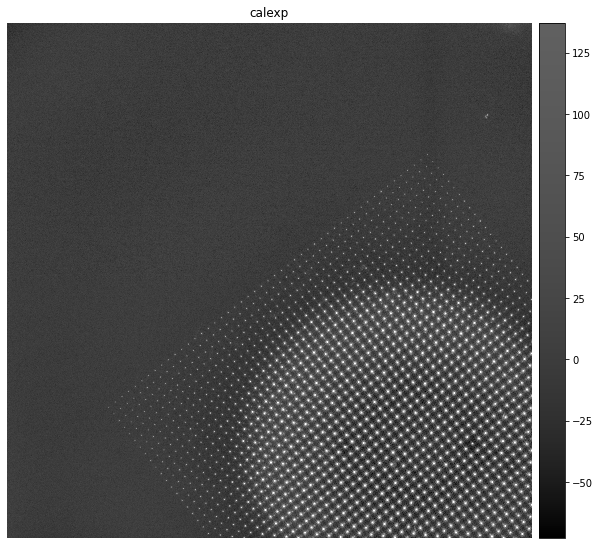

{instrument: 'LSSTCam', detector: 29, exposure: 3020112501820, ...}


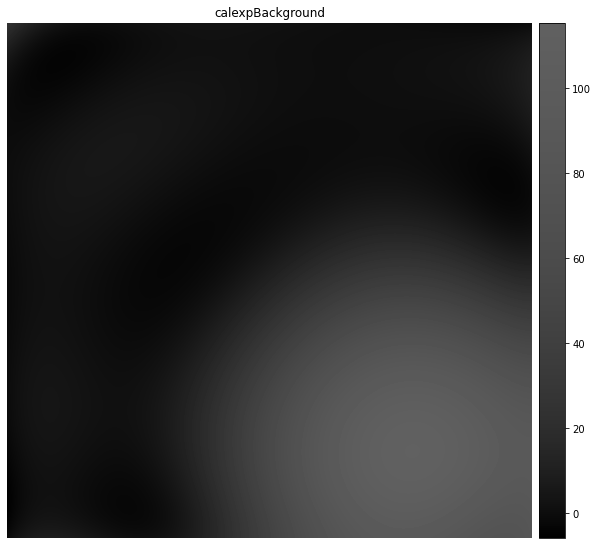

{instrument: 'LSSTCam', detector: 29, exposure: 3020112501820, ...}


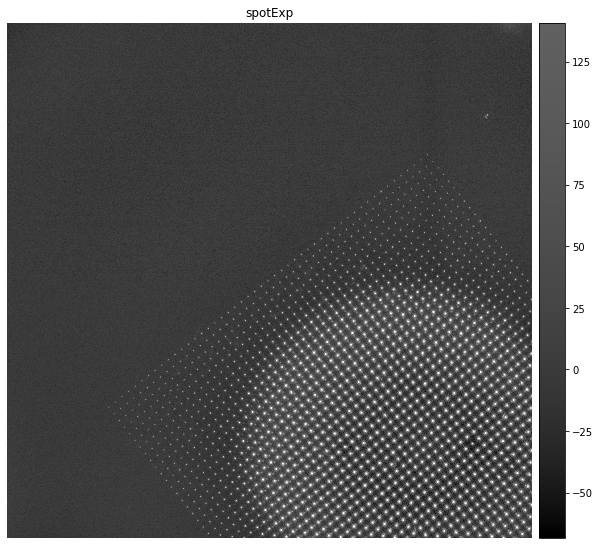

{instrument: 'LSSTCam', detector: 29, exposure: 3020112501820, ...}


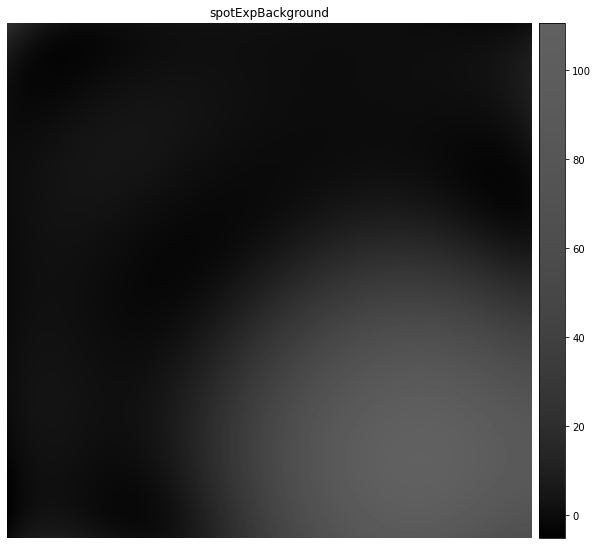

In [12]:
for atyp in ["postISRCCD","calexp","calexpBackground","spotExp","spotExpBackground"]:
    datasetRefs = list(subregistry.queryDatasets(datasetType=atyp,collections=collections))        
    print(datasetRefs[0].dataId)
    calexp = subbutler.get(datasetRefs[0])
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(calexp.getImage())
    plt.title(atyp)
    plt.gca().axis('off')
    plt.show()

Then we'll look source catalog. Depending on what a yaml file is used, the output name will be different. I used this [yaml](https://github.com/youtsumi/ButlerGen3Work/blob/master/cpSpot.yaml) file, so the source catalog will be named "spotSrc" or ,"src". So let's see how it looks.

In [9]:
datasetRefs = list(subregistry.queryDatasets(datasetType="spotSrc",collections=collections))        
datasetRefs[0].dataId
src = subbutler.get(datasetRefs[0])

Casting the catalog as astropy table

In [10]:
src.asAstropy()

id,coord_ra,coord_dec,parent,calib_psf_candidate,calib_psf_used,calib_psf_reserved,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,slot_Centroid_flag_badError,base_SdssShape_xx,slot_Shape_xx,base_SdssShape_yy,slot_Shape_yy,base_SdssShape_xy,slot_Shape_xy,base_SdssShape_xxErr,slot_Shape_xxErr,base_SdssShape_yyErr,slot_Shape_yyErr,base_SdssShape_xyErr,slot_Shape_xyErr,base_SdssShape_x,slot_Shape_x,base_SdssShape_y,slot_Shape_y,base_SdssShape_instFlux,slot_Shape_instFlux,base_SdssShape_instFluxErr,slot_Shape_instFluxErr,base_SdssShape_psf_xx,slot_PsfShape_xx,slot_Shape_psf_xx,base_SdssShape_psf_yy,slot_PsfShape_yy,slot_Shape_psf_yy,base_SdssShape_psf_xy,slot_PsfShape_xy,slot_Shape_psf_xy,base_SdssShape_instFlux_xx_Cov,slot_Shape_instFlux_xx_Cov,base_SdssShape_instFlux_yy_Cov,slot_Shape_instFlux_yy_Cov,base_SdssShape_instFlux_xy_Cov,slot_Shape_instFlux_xy_Cov,base_SdssShape_flag,base_GaussianFlux_flag_badShape,slot_Shape_flag,base_SdssShape_flag_unweightedBad,base_GaussianFlux_flag_badShape_unweightedBad,slot_Shape_flag_unweightedBad,base_SdssShape_flag_unweighted,base_GaussianFlux_flag_badShape_unweighted,slot_Shape_flag_unweighted,base_SdssShape_flag_shift,base_GaussianFlux_flag_badShape_shift,slot_Shape_flag_shift,base_SdssShape_flag_maxIter,base_GaussianFlux_flag_badShape_maxIter,slot_Shape_flag_maxIter,base_SdssShape_flag_psf,base_GaussianFlux_flag_badShape_psf,slot_Shape_flag_psf,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_9_0_instFlux,base_CircularApertureFlux_9_0_in

So picking up x, y and flux, we'll plot them in a plane

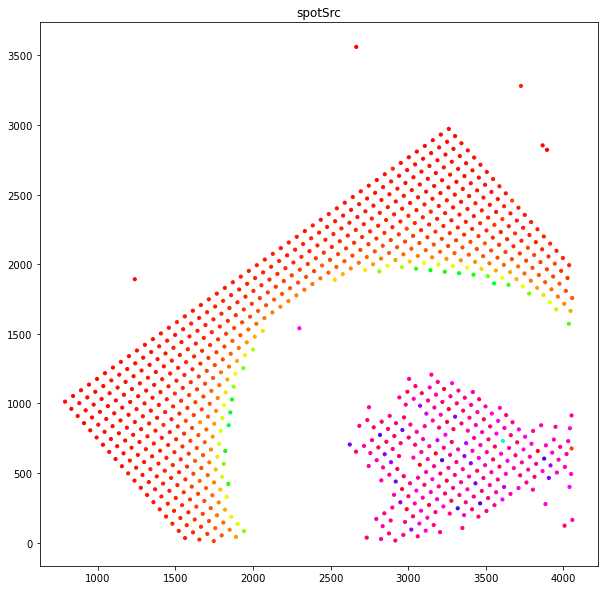

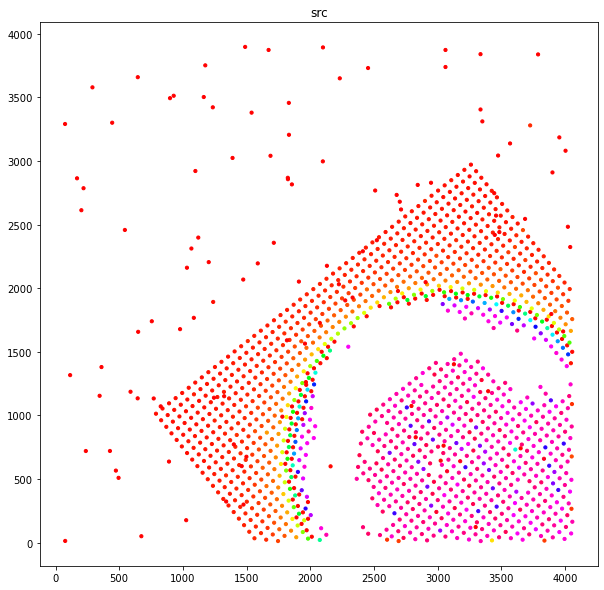

In [11]:
for atyp in ["spotSrc","src"]:
    datasetRefs = list(subregistry.queryDatasets(datasetType=atyp,collections=collections))        
    datasetRefs[0].dataId
    src = subbutler.get(datasetRefs[0])
    x = src["base_SdssCentroid_x"]
    y = src["base_SdssCentroid_y"]
    I = src["slot_ApFlux_instFlux"]
    fig = plt.figure(figsize=(10,10))
    plt.title(atyp)
    plt.scatter( x, y, c=(I/numpy.nanmax(I)), s=10,cmap='hsv' )